In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/train.csv')
data_test = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/test.csv')

In [3]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [4]:
data_train.head(100)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,1,2,"Gruska, Karen",female,53.00,0,0,325538,32.24,NaN,S
96,96,1,2,"Jordan, Emma",female,28.00,0,0,167707,26.46,NaN,Q
97,97,1,1,"Elliott, Monica",female,56.00,0,0,PC 11617,131.28,D7415,Q
98,98,1,2,"Bohn, Teresa",female,8.00,0,0,NaN,27.88,NaN,S


<h1>Check for missing values</h1>

In [5]:
print('Missing values in train dataset')
print(data_train.isnull().sum())

Missing values in train dataset
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64


In [6]:
print('Unique values in train dataset')
print(data_train.nunique())

Unique values in train dataset
PassengerId    100000
Survived            2
Pclass              3
Name            92144
Sex                 2
Age               173
SibSp               7
Parch               8
Ticket          75331
Fare            15935
Cabin           26992
Embarked            3
dtype: int64


In [7]:
print('Missing values in test dataset')
print(data_test.isnull().sum())

Missing values in test dataset
PassengerId        0
Pclass             0
Name               0
Sex                0
Age             3487
SibSp              0
Parch              0
Ticket          5181
Fare             133
Cabin          70831
Embarked         277
dtype: int64


In [8]:
print('Missing values in test dataset')
print(data_test.nunique())

Missing values in test dataset
PassengerId    100000
Pclass              3
Name            90808
Sex                 2
Age               159
SibSp               7
Parch               8
Ticket          75432
Fare            16554
Cabin           25216
Embarked            3
dtype: int64


In [9]:
def titanic_preprocessing(dataset):
    dataset['Cabin_class'] = dataset['Cabin'].str.extract(r'([a-zA-Z])')
    dataset['Cabin_number'] = dataset['Cabin'].str.extract(r'(\d+)')
    dataset['Ticket_prefix'] = dataset['Ticket'].str.extract(r'([a-zA-Z.]+)')
    dataset['Ticket_number'] = dataset['Ticket'].str.extract(r'(\d+)')
    dataset['NameLen'] = dataset['Name'].str.len() - 1
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 0, 'IsAlone'] = 1
    # dataset['FirstName'] = dataset['Name'].map(lambda x: x.split(', ')[1])
    # dataset['LastName'] = dataset['Name'].map(lambda x: x.split(', ')[0])
    # dataset['Title'] = dataset['Name'].map(lambda x: substrings_in_string(x, title_list))
    # df['Title'] = df.apply(replace_titles, axis=1)
    dataset['Age*Class'] = dataset['Age'] * dataset['Pclass']
    dataset['FarePerPerson'] = dataset['Fare'] / (dataset['FamilySize'] + 1)

    dataset['Cabin_class'].fillna('NoCabin', inplace = True)
    dataset['Cabin_number'].fillna(0, inplace = True)
    dataset['Ticket_prefix'].fillna('', inplace = True)

    # Bining
    labels = ['1', '2', '3', '4', '5']
    dataset['Fare_cut'] = pd.qcut(dataset['Fare'], q=5, labels=labels)

    # Delete useless columns
    dataset = dataset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    # Why I want to delete them?
    # PassengerId, Name - those feature will bring nothing to our prediction
    # Ticket - to many unique values
    # Cabin - to many missing values

     # Age fillna with mean age for each class
    age_map = dataset[['Age', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
    dataset['Age'] = dataset['Age'].fillna(dataset['Pclass'].map(age_map['Age']))

    # Fill Age column with median
    # dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    
    # Fill Embarked with most occuring values
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    
    # Fill Fare column with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

    # Bining
    labels = ['1', '2', '3', '4', '5']
    dataset['Fare_cut'] = pd.qcut(dataset['Fare'], q=5, labels=labels)

    return dataset

In [10]:
def titanic_feature_engineering(dataset):

    num_columns = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
    ord_columns_to_dummy = ['Cabin_class', 'Ticket_prefix', 'IsAlone', 'Embarked', 'Fare_cut']
    ord_couumns_to_change = ['Cabin_number', 'Ticket_number']

    # Create dummy variables
    dummy = pd.get_dummies(dataset[ord_columns_to_dummy], dtype=np.int32)
    dataset = pd.concat([dataset, dummy], axis=1)
    dataset.drop(ord_columns_to_dummy, axis=1, inplace=True)

    dataset['Ticket_number'].fillna(dataset['Ticket_number'].mode()[0], inplace=True)
    dataset['Age*Class'].fillna(dataset['Age*Class'].median(), inplace=True)
    dataset['FarePerPerson'].fillna(dataset['FarePerPerson'].median(), inplace=True)


    # Change type
    for column in ord_couumns_to_change:
        dataset[column] = dataset[column].astype(int)

    dataset['Sex_dummy'] = dataset['Sex'].map({'male': 0, 'female': 1})
    dataset.drop(['Sex'], axis=1, inplace=True)

    return dataset 

In [11]:
def dataset_preparation(dataset):
    dataset = titanic_preprocessing(dataset)
    dataset = titanic_feature_engineering(dataset)
    return dataset

In [12]:
data_train_copy = data_train.copy()
data_test_copy = data_test.copy()

data_train_prep = dataset_preparation(data_train_copy)
data_test_prep = dataset_preparation(data_test_copy)

In [13]:
data_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 61 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Survived              100000 non-null  int64  
 1   Pclass                100000 non-null  int64  
 2   Age                   100000 non-null  float64
 3   SibSp                 100000 non-null  int64  
 4   Parch                 100000 non-null  int64  
 5   Fare                  100000 non-null  float64
 6   Cabin_number          100000 non-null  int32  
 7   Ticket_number         100000 non-null  int32  
 8   NameLen               100000 non-null  int64  
 9   FamilySize            100000 non-null  int64  
 10  Age*Class             100000 non-null  float64
 11  FarePerPerson         100000 non-null  float64
 12  Cabin_class_A         100000 non-null  int32  
 13  Cabin_class_B         100000 non-null  int32  
 14  Cabin_class_C         100000 non-null  int32  
 15  C

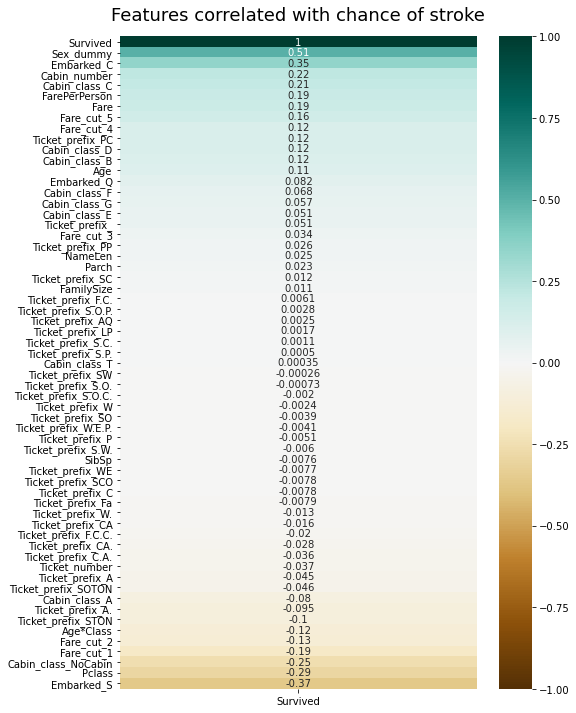

In [14]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_train_prep.corr()[['Survived']].sort_values(by='Survived', ascending=False),
                     vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features correlated with chance of stroke', fontdict={'fontsize': 18}, pad=16);

In [15]:
# fig = go.Figure()

# fig.add_trace(go.Box(
#     y = data_test_prep['Age'],
#     name = 'Age'
# ))

# fig.add_trace(go.Box(
#     y = data_test_prep['Fare'],
#     name = 'Fare'
# ))

# fig.update_layout(
#     title_text = 'Test dataset box plot'
# )

In [16]:
# fig = go.Figure()

# fig.add_trace(go.Box(
#     y = data_train_prep['Age'],
#     name = 'Age'
# ))

# fig.add_trace(go.Box(
#     y = data_train_prep['Fare'],
#     name = 'Fare'
# ))

# fig.update_layout(
#     title_text = 'Train dataset box plot'
# )

In [17]:
# fig = go.Figure()

# fig.add_trace(go.Box(
#     y = data_train_prep['Age'],
#     name = 'Age'
# ))

# fig.add_trace(go.Box(
#     y = data_train_prep['Fare'],
#     name = 'Fare'
# ))

# fig.update_layout(
#     title_text = 'Train dataset box plot'
# )

In [18]:
data_train_prep

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_number,Ticket_number,NameLen,FamilySize,...,Ticket_prefix_WE,Embarked_C,Embarked_Q,Embarked_S,Fare_cut_1,Fare_cut_2,Fare_cut_3,Fare_cut_4,Fare_cut_5,Sex_dummy
0,1,1,47.00,2,0,27.14,12239,209245,15,3,...,0,0,0,1,0,0,1,0,0,0
1,0,3,30.00,0,0,13.35,0,27323,10,1,...,0,0,0,1,0,1,0,0,0,0
2,0,3,0.33,1,2,71.29,0,457703,13,4,...,0,0,0,1,0,0,0,0,1,0
3,0,3,19.00,0,0,13.04,0,10866,12,1,...,0,0,0,1,0,1,0,0,0,0
4,1,3,25.00,0,0,7.76,0,427635,12,1,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,62.00,0,0,14.86,17243,15008,10,1,...,0,1,0,0,0,0,1,0,0,1
99996,0,2,66.00,0,0,11.15,0,13273,12,1,...,0,0,0,1,0,1,0,0,0,0
99997,0,3,37.00,0,0,9.95,0,5,17,1,...,0,0,0,1,0,1,0,0,0,0
99998,0,3,51.00,0,1,30.92,0,458654,15,2,...,0,0,0,1,0,0,0,1,0,0


In [19]:
# Split data into train and validation sets
X = data_train_prep.drop(['Survived'], axis=1)
y = data_train_prep['Survived']

# Scalling
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
data_test_scaled = scaler.fit_transform(data_test_prep)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
def model_evaluation(model):
    # Train our model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores1 = cross_val_score(model, X, y, scoring = 'f1' ,cv=5)
    print(scores1)

    scores2 = cross_val_score(model, X, y, cv=5)
    print(scores2)

    # Accuracy score
    acc =  accuracy_score(y_test, y_pred)
    print('Acc score: {}'.format(acc))
    
    # F1 score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: {}'.format(f1))

    # AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
    AUC = auc(fpr, tpr)
    print('AUC score: {}'.format(AUC))
    
    # Confusion matrix
    print('Confusion Matrix: ')
    matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts =['{0:0.0f}'.format(value) for value in matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(matrix, annot=labels, fmt='', cmap='rocket_r')
    
    return f1

In [21]:
# K-nearest neighbors 
KNN_model = KNeighborsClassifier()

# SVC
# SVC_model = SVC()

# Logistic regression
LR_model = LogisticRegression(max_iter=1000)

# Decision tree
DT_model = DecisionTreeClassifier()

# Random Forest
RF_model = RandomForestClassifier()

# Stochastic gradient descent
SGD_model = SGDClassifier()

# XGBoost
XGB_model = xgb.XGBClassifier()

# LightGBM
LGBM_model = LGBMClassifier()

In [22]:
f1_for_KNN = model_evaluation(KNN_model)

In [43]:
# f1_for_SVC = model_evaluation(SVC_model)

[0.73388922 0.73098642 0.73781463 0.73777778 0.73099171]
Acc score: 0.7782666666666667
F1 score: 0.734747587526916
AUC score: nan
Confusion Matrix: 


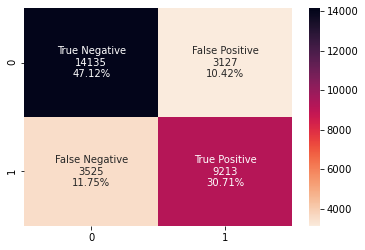

In [44]:
f1_for_LR = model_evaluation(LR_model)

[0.64382766 0.64346201 0.63972206 0.63620962 0.63811413]
Acc score: 0.6915
F1 score: 0.6405685657695445
AUC score: nan
Confusion Matrix: 


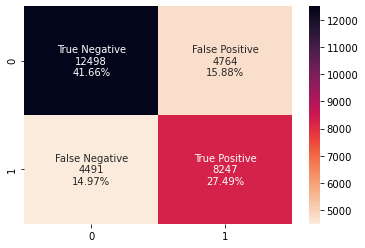

In [45]:
f1_for_DT = model_evaluation(DT_model)

[0.72738067 0.72586919 0.72658467 0.72737997 0.7249388 ]
Acc score: 0.7682333333333333
F1 score: 0.7237474671222537
AUC score: nan
Confusion Matrix: 


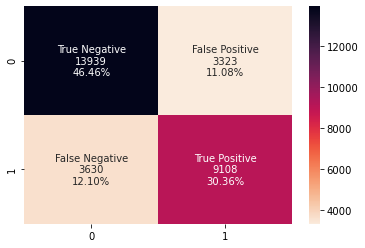

In [46]:
f1_for_RF = model_evaluation(RF_model)

[0.71794577 0.72065578 0.7168819  0.71628506 0.7167387 ]
Acc score: 0.7603333333333333
F1 score: 0.7187451103113754
AUC score: nan
Confusion Matrix: 


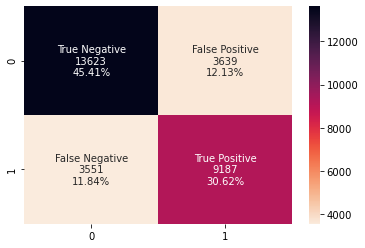

In [47]:
f1_for_SGD = model_evaluation(SGD_model)

[0.74337015 0.74283672 0.74710141 0.74363669 0.74145413]
Acc score: 0.7838666666666667
F1 score: 0.7426779903166917
AUC score: nan
Confusion Matrix: 


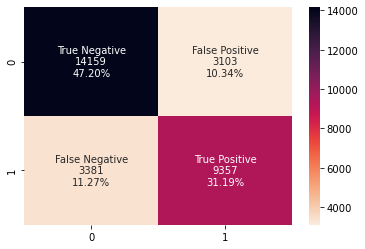

In [48]:
f1_for_XGB = model_evaluation(XGB_model)

[0.7444668  0.74308963 0.74864801 0.74394423 0.74152214]
Acc score: 0.7850333333333334
F1 score: 0.7443206597153392
AUC score: nan
Confusion Matrix: 


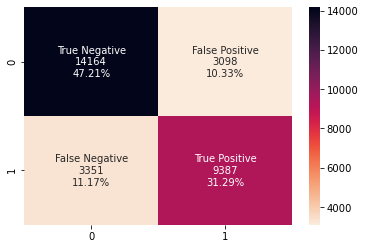

In [49]:
f1_for_LGBM = model_evaluation(LGBM_model)

In [50]:
# XGBoost
XGB_model = xgb.XGBClassifier(n_estimators=450)

eval_set = [(X_train, y_train), (X_test, y_test)]
model = XGB_model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, early_stopping_rounds=50)

	validation_1-logloss:0.467775
[176]	validation_0-error:0.2129	validation_0-logloss:0.462563	validation_1-error:0.216033	validation_1-logloss:0.467768
[177]	validation_0-error:0.212871	validation_0-logloss:0.462526	validation_1-error:0.216033	validation_1-logloss:0.467775
[178]	validation_0-error:0.212843	validation_0-logloss:0.462495	validation_1-error:0.216033	validation_1-logloss:0.467782
[179]	validation_0-error:0.212943	validation_0-logloss:0.46242	validation_1-error:0.216033	validation_1-logloss:0.467743
[180]	validation_0-error:0.212886	validation_0-logloss:0.462365	validation_1-error:0.215933	validation_1-logloss:0.467725
[181]	validation_0-error:0.212729	validation_0-logloss:0.462317	validation_1-error:0.215967	validation_1-logloss:0.467723
[182]	validation_0-error:0.2127	validation_0-logloss:0.462247	validation_1-error:0.215967	validation_1-logloss:0.467695
[183]	validation_0-error:0.212643	validation_0-logloss:0.462182	validation_1-error:0.215733	validation_1-logloss:0.46766

[0.74373341 0.74240249 0.74633543 0.74306621 0.74198727]
Acc score: 0.7840333333333334
F1 score: 0.7427436966448283
AUC score: nan
Confusion Matrix: 


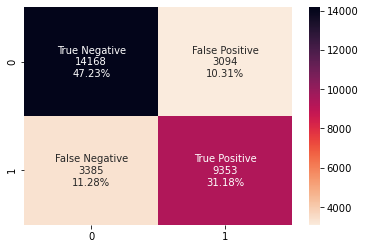

In [51]:
f1_for_XGB = model_evaluation(XGB_model)

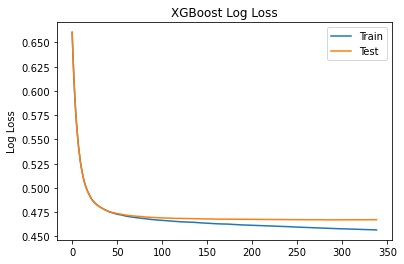

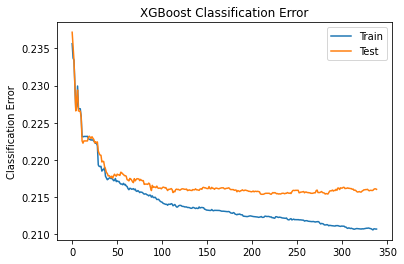

In [52]:
results = XGB_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [53]:
y_pred = LGBM_model.predict(data_test_prep)

In [54]:
my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
my_submission.to_csv('submission_now.csv', index=False)

Pamiętaj, że najlepszy jest lightboost